# Intro
Welcome to the [Google Landmark Recognition 2021](https://www.kaggle.com/c/landmark-recognition-2021) compedition
![](https://storage.googleapis.com/kaggle-competitions/kaggle/29762/logos/header.png)

This notebook will give you a guideline to start step by step with this compedition. We focus on:
* the underlying structure of the data,
* a data generator to load the image data on demand during the prediction process.

We use a simple model with a pretrained model on a subset of the train data to clarify the workflow. Additionally we recommend to use the power of GPU.


<span style="color: royalblue;">Please vote the notebook up if it helps you. Feel free to leave a comment above the notebook. Thank you. </span>

# Libraries
We use some standard python packages and the libraries of scikit learn and keras. 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split

from keras.utils import to_categorical, Sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.optimizers import RMSprop,Adam
from keras.applications import VGG19, VGG16, ResNet50

import warnings
warnings.filterwarnings("ignore")

# Path

In [2]:
#path = '/kaggle/input/landmark-recognition-2021/'
path = '../../landmark-recognition-2021/'
os.listdir(path)

['test', 'train', 'sample_submission.csv', 'train.csv']

# Load Data

In [3]:
train_data = pd.read_csv(path+'train.csv')
samp_subm = pd.read_csv(path+'sample_submission.csv')

In [4]:
train_data.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [5]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,137790 0.1
1,000b15b043eb8cf0,137790 0.1
2,0011a52f9b948fd2,137790 0.1
3,00141b8a5a729084,137790 0.1
4,0018aa4b92532b77,137790 0.1


# Functions

In [6]:
def plot_examples(landmark_id=1):
    """ Plot 5 examples of images with the same landmark_id """
    
    fig, axs = plt.subplots(1, 5, figsize=(25, 12))
    fig.subplots_adjust(hspace = .2, wspace=.2)
    axs = axs.ravel()
    for i in range(5):
        idx = train_data[train_data['landmark_id']==landmark_id].index[i]
        image_id = train_data.loc[idx, 'id']
        file = image_id+'.jpg'
        subpath = '/'.join([char for char in image_id[0:3]])
        img = cv2.imread(path+'train/'+subpath+'/'+file)
        axs[i].imshow(img)
        axs[i].set_title('landmark_id: '+str(landmark_id))
        axs[i].set_xticklabels([])
        axs[i].set_yticklabels([])

# Overview
First we look on the size of the dataset:

In [7]:
print('Samples train:', len(train_data))
print('Samples test:', len(samp_subm))

Samples train: 1580470
Samples test: 10345


In [8]:
train_data.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


There are 81313 unique classes:

In [9]:
len(train_data['landmark_id'].unique())

81313

For each test image, we have to predict one landmark label and a corresponding confidence score. 

In [10]:
samp_subm.head()

,id,landmarks
0,00084cdf8f600d00,137790 0.1
1,000b15b043eb8cf0,137790 0.1
2,0011a52f9b948fd2,137790 0.1
3,00141b8a5a729084,137790 0.1
4,0018aa4b92532b77,137790 0.1


# Find Image
We consider the first image of the train data set and plot it. The first 3 characters ares used for the subpath which is the location of the image. 

In [11]:
train_data.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [12]:
image_id = train_data.loc[0, 'id']
file = image_id+'.jpg'
subpath = '/'.join([char for char in image_id[0:3]]) 

In [13]:
file

'17660ef415d37059.jpg'

In [14]:
subpath

'1/7/6'

Is the file located in the subpath?

In [15]:
file in os.listdir(path+'train/'+subpath)

True

In [16]:
path

'../../landmark-recognition-2021/'

Plot the image:

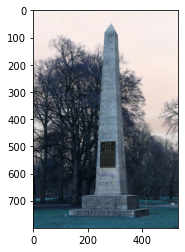

In [17]:
img = cv2.imread(path+'train/'+subpath+'/'+file)
plt.imshow(img)
plt.show()

Look on the image shape:

In [18]:
img.shape

(800, 533, 3)

# Plot Some Examples
We plot some examples of images with the same **landmark_id** in a row.

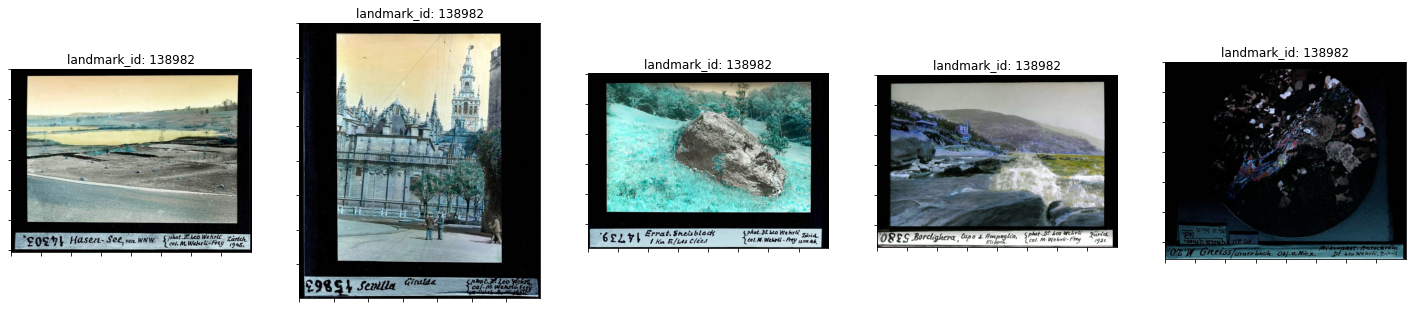

In [19]:
plot_examples(landmark_id = 138982)

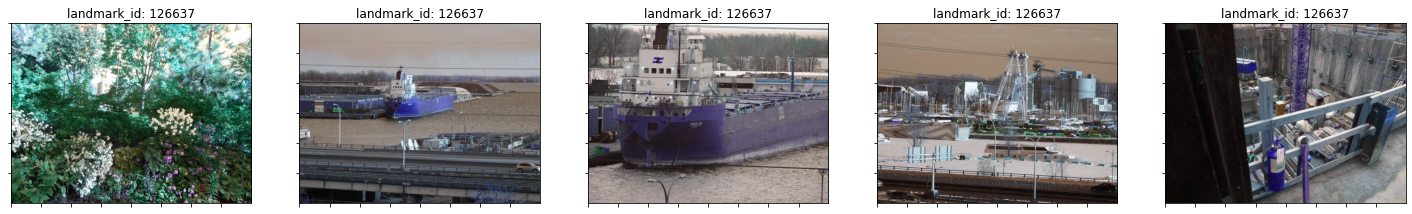

In [20]:
plot_examples(landmark_id = 126637)

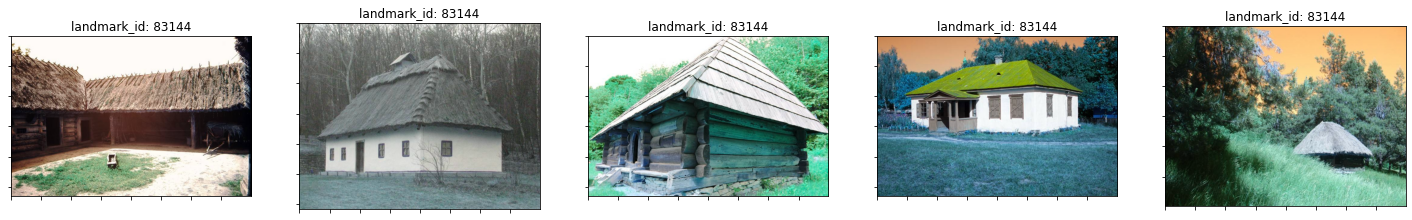

In [21]:
plot_examples(landmark_id = 83144)

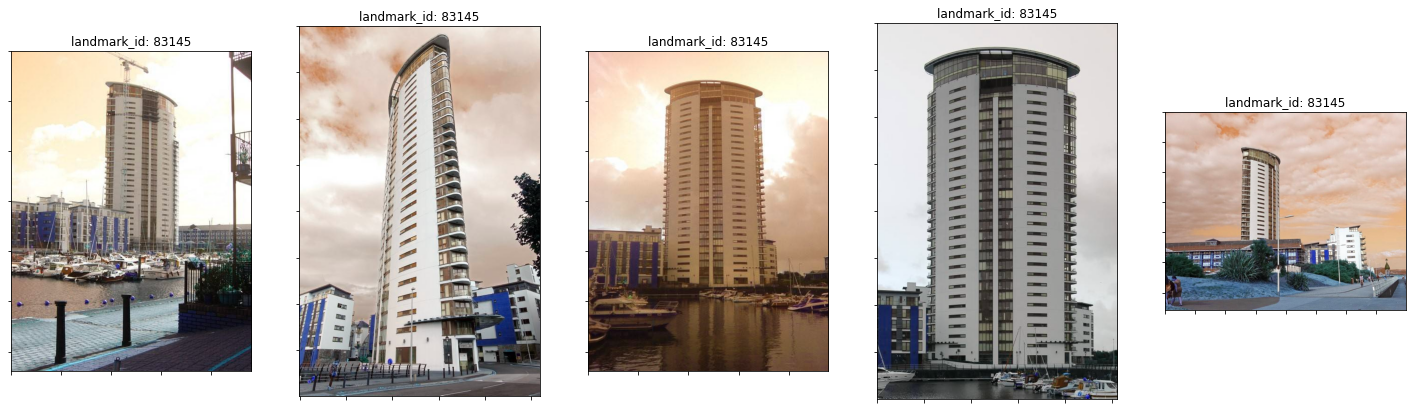

In [22]:
plot_examples(landmark_id = 83145)

In [23]:
idx = train_data[train_data['landmark_id']==83145].index[0]
print(idx)
print('-------')
print(train_data.loc[idx])
print('-------')
image_id = train_data.loc[idx, 'id']
image_id

648377
-------
id             01cb5d79b5aef445
landmark_id               83145
Name: 648377, dtype: object
-------


'01cb5d79b5aef445'

# Split Data
We define train, validation and test data.

In [24]:
train_data.index[0:3]

RangeIndex(start=0, stop=3, step=1)

In [25]:
list(train_data.index)[:15]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

In [26]:
list_IDs_trainA, list_IDs_valA = train_test_split(list(train_data.index)[:15], test_size=0.33, random_state=2021)
print('---- list_IDs_trainA -----')
print(list_IDs_trainA)
print('---list_IDs_valA-----')
print(list_IDs_valA)
print('-----------')
list_IDs_testA = list(samp_subm.index)[:15]
print('---- list_IDs_testA-----')
print(list_IDs_testA)
print('-----------')

---- list_IDs_trainA -----
[1, 10, 14, 8, 13, 6, 0, 9, 5, 4]
---list_IDs_valA-----
[3, 11, 7, 2, 12]
-----------
---- list_IDs_testA-----
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
-----------


In [27]:
train_data.iloc[train_data.index[0:3]]

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1


In [28]:
#500000
list_IDs_train, list_IDs_val = train_test_split(list(train_data.index)[:100000], test_size=0.33, random_state=2021)
list_IDs_test = list(samp_subm.index)

In [29]:
print('Number train samples:', len(list_IDs_train))
print('Number val samples:', len(list_IDs_val))
print('Number test samples:', len(list_IDs_test))

Number train samples: 67000
Number val samples: 33000
Number test samples: 10345


# Data Generator

We use a data generator to load the data on demand.

In [30]:
img_size = 32
img_channel = 3
batch_size = 64

num_classes = len(train_data['landmark_id'].value_counts())

In [31]:
num_classes

81313

# DataGenerator

In [32]:
class DataGenerator(Sequence):
    def __init__(self, path, list_IDs, data, img_size, img_channel, batch_size):
        self.path = path
        self.list_IDs = list_IDs
        self.data = data
        self.img_size = img_size
        self.img_channel = img_channel
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.list_IDs))
        
    def __len__(self):
        len_ = int(len(self.list_IDs)/self.batch_size)
        if len_*self.batch_size < len(self.list_IDs):
            len_ += 1
        return len_
    
    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        list_IDs_temp = [self.list_IDs[k] for k in indexes]
        X, y = self.__data_generation(list_IDs_temp)
        return X, y
            
    
    def __data_generation(self, list_IDs_temp):
        X = np.zeros((self.batch_size, self.img_size, self.img_size, self.img_channel))
        y = np.zeros((self.batch_size, 1), dtype=int)
        for i, ID in enumerate(list_IDs_temp):
            
            image_id = self.data.loc[ID, 'id']
            file = image_id+'.jpg'
            subpath = '/'.join([char for char in image_id[0:3]]) 
            
            img = cv2.imread(self.path+subpath+'/'+file)
            
            img = cv2.resize(img, (self.img_size, self.img_size))
            X[i, ] = img/255
            if self.path.find('train')>=0:
                y[i, ] = self.data.loc[ID, 'landmark_id']
            else:
                y[i, ] = 0
        return X, y

Use the DataGenerator class to define the data generators for train, validation and test data:

In [33]:
train_generator = DataGenerator(path+'train/', list_IDs_train, train_data, img_size, img_channel, batch_size)
val_generator = DataGenerator(path+'train/', list_IDs_val, train_data, img_size, img_channel, batch_size)
test_generator = DataGenerator(path+'test/', list_IDs_test, samp_subm, img_size, img_channel, batch_size)

In [34]:
train_generator.data[:5]

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [35]:
# data_generation(list_IDs_train)


# Model

Load pretrained model:

In [36]:
weights='resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'
conv_base = ResNet50(weights=weights,
                     include_top=False,
                     input_shape=(img_size, img_size, img_channel))
conv_base.trainable = True

Define Model

In [37]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
#model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer = Adam(lr=1e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 1, 1, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 81313)             166610337 
Total params: 190,198,049
Trainable params: 190,144,929
Non-trainable params: 53,120
_________________________________________________________________


In [38]:
epochs = 2

In [39]:
history = model.fit_generator(generator=train_generator,
                              validation_data=val_generator,
                              epochs = epochs, workers=4)

Epoch 1/2
   5/1047 [..............................] - ETA: 45:42 - loss: 11.4049 - sparse_categorical_accuracy: 0.0000e+00

KeyboardInterrupt: 

In [ ]:
print("Train done")

In [ ]:
# list all data in history
print(history.history.keys())

In [ ]:
history.history['loss']

In [ ]:
plt.plot(history.history['loss'])

# Predict Test Data

In [ ]:
y_pred = model.predict_generator(test_generator, verbose=1)

In [ ]:
y_pred.shape

In [ ]:
for i in range(len(samp_subm.index)):
    category = np.argmax(y_pred[i])
    score = y_pred[i][np.argmax(y_pred[i])].round(2)
    samp_subm.loc[i, 'landmarks'] = str(category)+' '+str(score)

In [ ]:
samp_subm.head()

# Export

In [ ]:
samp_subm.to_csv('submission.csv', index=False)